In [1]:
import pandas as pd
import re
import string
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("imbd.csv" , header= None )

In [3]:
col_names = ["Movie Name" ,"Movie Category","Movie General Rate","Year" ,"Score" ,"Age Limit" ,"User Name" ,"Comment","den"]

In [4]:
df.columns = col_names

In [5]:
df = df.rename(columns = {"Comment" : "Comment Title" , "den" : "Comment"})

In [6]:
df = df.drop( columns=["Movie General Rate" , "Movie Category" , "Year" , "Score" , "Age Limit", "Comment Title"] ,axis=1)
df.head()

,Movie Name,User Name,Comment
0,Esaretin Bedeli,Sleepin_Dragon,It is no wonder that the film has such a high ...
1,Esaretin Bedeli,EyeDunno,I'm trying to save you money; this is the last...
2,Esaretin Bedeli,alexkolokotronis,This movie is not your ordinary Hollywood flic...
3,Esaretin Bedeli,auuwws,The best movie in history and the best ending ...
4,Esaretin Bedeli,Coxer99,One of the finest films made in recent years. ...


In [7]:
n = len(pd.unique(df['Movie Name']))
print(n)

60


In [8]:
df = df.drop("User Name" , axis=1)
df.head()

,Movie Name,Comment
0,Esaretin Bedeli,It is no wonder that the film has such a high ...
1,Esaretin Bedeli,I'm trying to save you money; this is the last...
2,Esaretin Bedeli,This movie is not your ordinary Hollywood flic...
3,Esaretin Bedeli,The best movie in history and the best ending ...
4,Esaretin Bedeli,One of the finest films made in recent years. ...


In [9]:
sw_nltk = stopwords.words('english')

def stop_words(text):
    words = [word for word in text.split() if word.lower() not in sw_nltk]
    new_text = " ".join(words)
    return new_text

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d' , '' , text)
    text = re.sub(r'[^\w\s]' , '' , text)
    #tokens = nltk.word_tokenize(text)
    return text



In [10]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    word_tokens  = text.split()
    lemmas = [lemmatizer.lemmatize(word , pos="v") for word in word_tokens]
    return lemmas

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def general_preprocess_data(text):
    cleaned_stop_words = stop_words(text)
    temp_preprocess_text = preprocess_text(cleaned_stop_words)
    result_text  = lemmatize_word(temp_preprocess_text)
    return result_text
    

In [12]:
#TEST METHOD FOR PREPROCESSING 
text_data = "It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't said before? Not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. Sometimes you watch a film, and can't remember it days later, this film loves with you, once you've seen it, you don't forget"

cleaned_data =  general_preprocess_data(text_data)
print(cleaned_data)
print(type(cleaned_data))

['wonder', 'film', 'high', 'rat', 'quite', 'literally', 'breathtaking', 'say', 'say', 'before', 'much', 'story', 'act', 'premise', 'all', 'movie', 'make', 'feel', 'sometimes', 'watch', 'film', 'cant', 'remember', 'days', 'later', 'film', 'love', 'you', 'see', 'it', 'forget']
<class 'list'>


In [13]:
df["Comment"] = df["Comment"].apply(general_preprocess_data)
df.head()

,Movie Name,Comment
0,Esaretin Bedeli,"[wonder, film, high, rat, quite, literally, br..."
1,Esaretin Bedeli,"[im, try, save, money, last, film, title, cons..."
2,Esaretin Bedeli,"[movie, ordinary, hollywood, flick, great, dee..."
3,Esaretin Bedeli,"[best, movie, history, best, end, entertainmen..."
4,Esaretin Bedeli,"[one, finest, film, make, recent, years, poign..."


PREPARE APRİORİ

In [16]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori , association_rules

def prepare_data(df):
    transactions = []
    for _, row in df.iterrows():
        transaction = row['Comment']  # Yorumları birleştirme
        transactions.append(transaction)
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    return df_encoded
    
def frequent_pattern_mining(df_encoded , min_support =0.2):
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True , verbose= 1)
    return frequent_itemsets.sort_values(by = "support" , ascending=False)
    

In [17]:

df_encoded = prepare_data(df)

frequent_itemsets = frequent_pattern_mining(df_encoded)


frequent_itemsets_str = frequent_itemsets.to_string()
with open("frequent_itemsets_output.txt", "w") as f:
    f.write(frequent_itemsets_str)

print(frequent_itemsets)

Processing 50 combinations | Sampling itemset size 5
      support                 itemsets
15   0.739653                   (film)
36   0.665554                    (one)
32   0.604139                  (movie)
29   0.563418                   (make)
50   0.537383                   (time)
..        ...                      ...
223  0.200267              (see, much)
307  0.200267       (make, film, well)
116  0.200267             (film, look)
325  0.200267          (make, one, go)
359  0.200267  (see, one, movie, film)

[361 rows x 2 columns]


<Axes: >

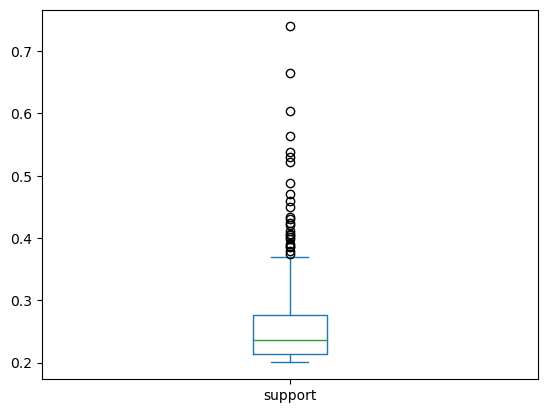

In [18]:
# box-plot for support items
frequent_itemsets["support"].plot.box()

In [19]:
solve = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.6)
last_solve = solve.sort_values(by="support")
solve_str = last_solve.to_string()
with open("association_rules_output.txt", "w") as f:
    f.write(solve_str)

solve

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(film),(one),0.739653,0.665554,0.529372,0.715704,1.075351,0.037094,1.176400,0.269143
1,(one),(film),0.665554,0.739653,0.529372,0.795386,1.075351,0.037094,1.272383,0.209513
2,(make),(film),0.563418,0.739653,0.449266,0.797393,1.078064,0.032532,1.284988,0.165860
3,(film),(make),0.739653,0.563418,0.449266,0.607401,1.078064,0.032532,1.112030,0.278135
4,(see),(film),0.522029,0.739653,0.433912,0.831202,1.123773,0.047791,1.542360,0.230434
...,...,...,...,...,...,...,...,...,...,...
456,"(one, go)",(make),0.281709,0.563418,0.200267,0.710900,1.261764,0.041547,1.510145,0.288823
457,"(see, one, movie)",(film),0.250334,0.739653,0.200267,0.800000,1.081588,0.015107,1.301736,0.100623
458,"(see, one, film)",(movie),0.331108,0.604139,0.200267,0.604839,1.001158,0.000232,1.001771,0.001730
459,"(see, film, movie)",(one),0.255007,0.665554,0.200267,0.785340,1.179980,0.030546,1.558029,0.204737
